In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score

In [2]:
# Load the dataset and display the first 5 rows
df = pd.read_csv('./Loan_default.csv')
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


The target feature for this dataset is 'Default' as it's the column with 0's and 1's as values due to this being a binary classification task.

# 1. Perform Exploratory Data Analysis (EDA)

### Number of rows and columns

In [3]:
rows, cols = df.shape
print(f'Rows: {rows}')
print(f'Columns: {cols}')

Rows: 255347
Columns: 18


### Data Types

In [4]:
print('Data Types: ')
df.dtypes

Data Types: 


LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

There is a mostly even mix of numerical and categorical features. We plan to use one-hot encoding on the categorical features and scale the numerical features.

### Statistics for numerical columns

In [5]:
# Generate summary statistics and round them
summary_stats = df.describe().round(2)

# Convert the summary statistics into a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

summary_stats_df.drop(columns='Default')

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio
count,255347.00,255347.00,255347.00,255347.00,255347.00,255347.00,255347.00,255347.00,255347.00
mean,43.50,82499.30,127578.87,574.26,59.54,2.50,13.49,36.03,0.50
std,14.99,38963.01,70840.71,158.90,34.64,1.12,6.64,16.97,0.23
min,18.00,15000.00,5000.00,300.00,0.00,1.00,2.00,12.00,0.10
25%,31.00,48825.50,66156.00,437.00,30.00,2.00,7.77,24.00,0.30
50%,43.00,82466.00,127556.00,574.00,60.00,2.00,13.46,36.00,0.50
75%,56.00,116219.00,188985.00,712.00,90.00,3.00,19.25,48.00,0.70
max,69.00,149999.00,249999.00,849.00,119.00,4.00,25.00,60.00,0.90


On average, the loan term is 36.03 months, or about 3 years. The average interest rate is 13.49%, while the average credit score is 574.26, which tells me that the type of loan is most likely not a credit card and installment type of loan, which usually carries high interest rates. The average loan amounts are higher compared to the average income, about 1.5 times, which probably explains why the term is about 3 years on average, especially considering the majority of people are able to pay off their loans as shown below with the target variable distribution. Borrowers tend to be older and higher income on average as there are no extreme outliers to skew the data.

### Statistics for categorical columns

In [6]:
# Create an empty list to store the analysis for each categorical column
categorical_analysis = []

# Loop through each categorical column and gather information
categorical_columns = df.select_dtypes(include=['object'])
categorical_columns = categorical_columns.drop(columns='LoanID')

for col in categorical_columns:
    # Get unique value count
    unique_values = df[col].nunique()
    
    # Get the mode (most frequent value)
    mode = df[col].mode()[0]
    mode_count = df[col].value_counts().iloc[0]
    mode_pct = (mode_count / len(df)) * 100

    # Get the second mode (second most frequent value if it exists)
    if len(df[col].value_counts()) > 1:
        second_mode = df[col].value_counts().index[1]
        second_mode_count = df[col].value_counts().iloc[1]
        second_mode_pct = (second_mode_count / len(df)) * 100
    else:
        second_mode = None
        second_mode_count = 0
        second_mode_pct = 0

    # Append the results to the list
    categorical_analysis.append({
        'Feature': col,
        'Unique Values': unique_values,
        'Mode': mode,
        'Mode Count': mode_count,
        'Mode %': mode_pct,
        'Second Mode': second_mode,
        'Second Mode Count': second_mode_count,
        'Second Mode %': second_mode_pct
    })

# Convert the list of dictionaries into a DataFrame
categorical_analysis_df = pd.DataFrame(categorical_analysis)

# Display the resulting DataFrame without index
categorical_analysis_df.style.hide()

Feature,Unique Values,Mode,Mode Count,Mode %,Second Mode,Second Mode Count,Second Mode %
Education,4,Bachelor's,64366,25.207267,High School,63903,25.025945
EmploymentType,4,Part-time,64161,25.126984,Unemployed,63824,24.995007
MaritalStatus,3,Married,85302,33.406306,Divorced,85033,33.300959
HasMortgage,2,Yes,127677,50.001371,No,127670,49.998629
HasDependents,2,Yes,127742,50.026826,No,127605,49.973174
LoanPurpose,5,Business,51298,20.089525,Home,51286,20.084826
HasCoSigner,2,Yes,127701,50.010770,No,127646,49.989230


As shown above, the modes take up very similar shares of representation in the data. Perhaps each category in each feature has fairly equal representation. More observation has to be done to be sure.

In [7]:
def detect_outliers_iqr(df, column):
    """
    Detect outliers in a column using the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column (str): The column to check for outliers.
    
    Returns:
    DataFrame: A DataFrame containing the outliers for that column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    lower_outliers = df[df[column] < lower_bound]
    upper_outliers = df[df[column] > upper_bound]
    # outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers = pd.concat([lower_outliers, upper_outliers], axis=0)
    
    return outliers, lower_outliers, upper_outliers, lower_bound, upper_bound


# Step 1: Select all numerical columns from the DataFrame
numerical_columns = df.select_dtypes(include=['float64', 'int64']).drop(columns='Default').columns

# Step 2: Detect outliers for each numerical column
outliers_dict = {}
for col in numerical_columns:
    outliers, *_ = detect_outliers_iqr(df, col)
    if not outliers.empty:  # Only store columns with outliers
        outliers_dict[col] = outliers

# Step 3: Display the outliers for each numerical column
if outliers_dict:
    print("Using IQR Rule we found outliers in:")
    for col, outliers in outliers_dict.items():
        print(f"  '{col}': {len(outliers)} entries")
else:
    print("No outliers detected in any numerical columns.")


No outliers detected in any numerical columns.


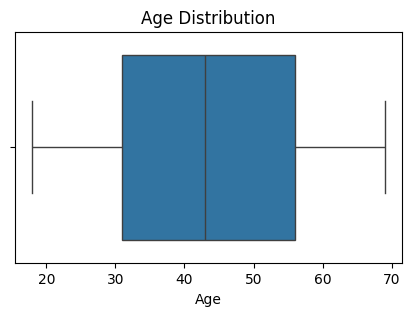

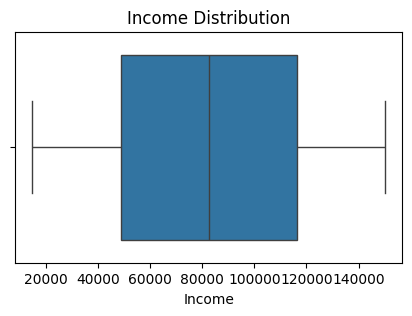

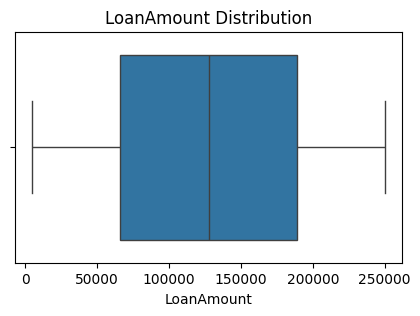

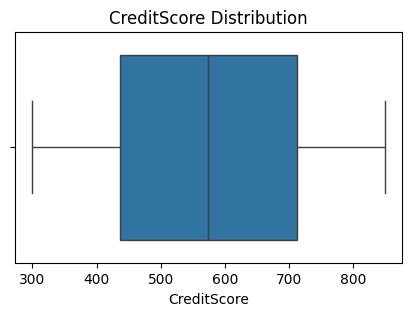

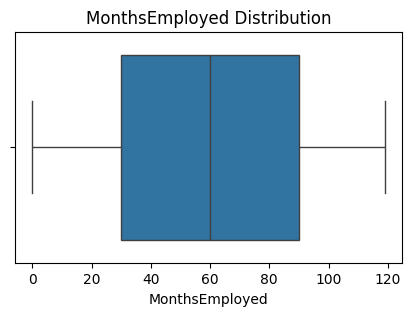

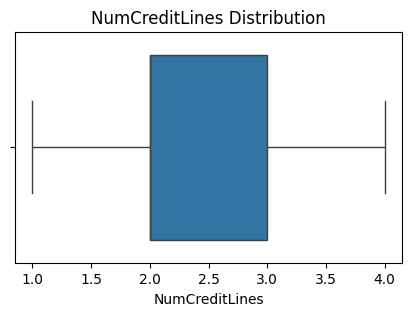

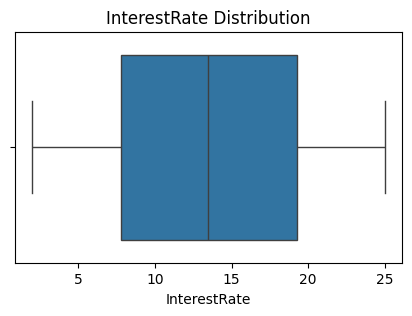

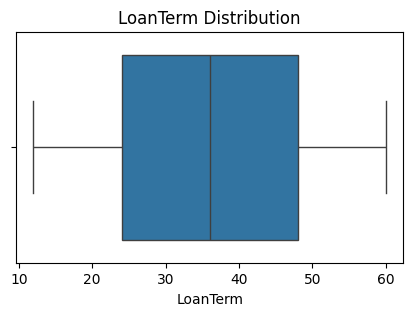

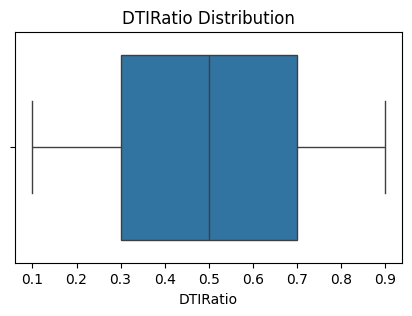

In [8]:
# Visualize outliers for each numerical column using boxplots
for col in numerical_columns:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f'{col} Distribution')

No outliers present and the distribution of the variables are very similar, possibly due to the data most likely being synthetic data.

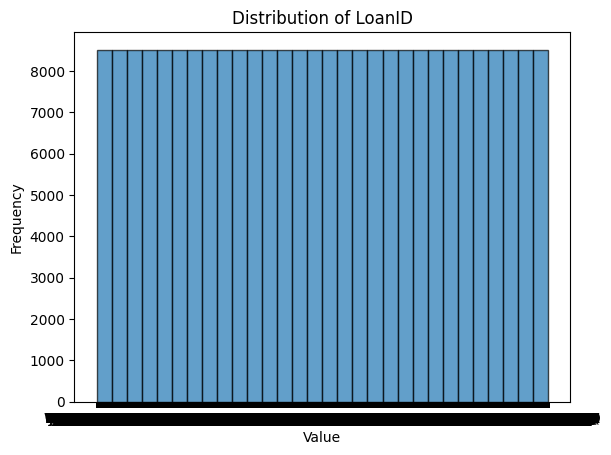

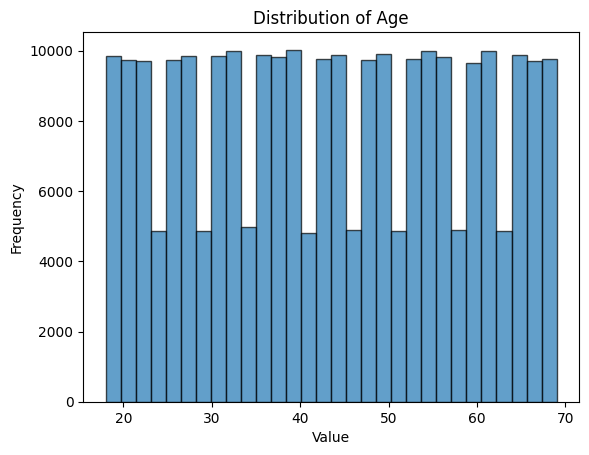

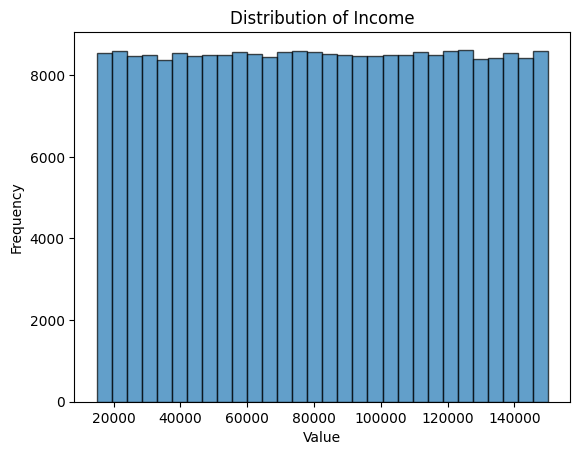

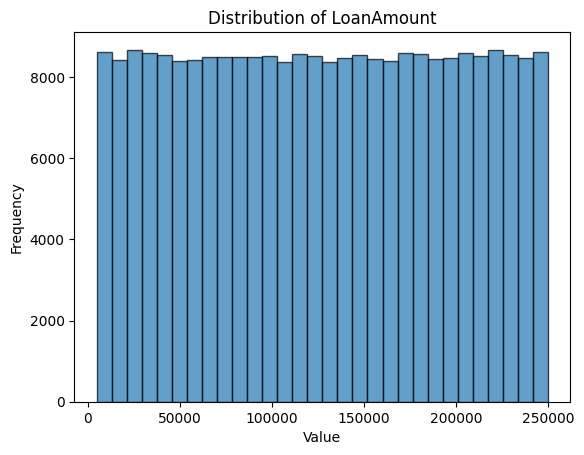

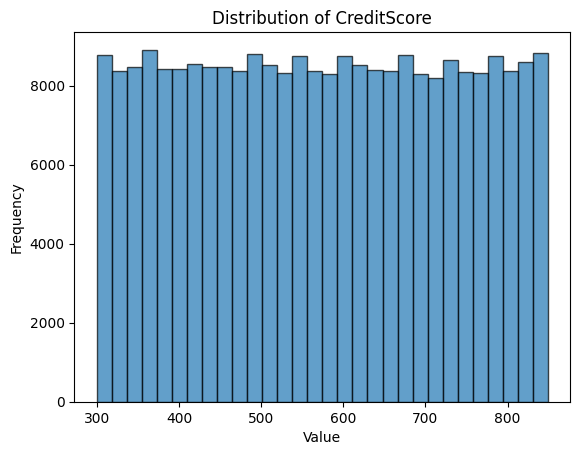

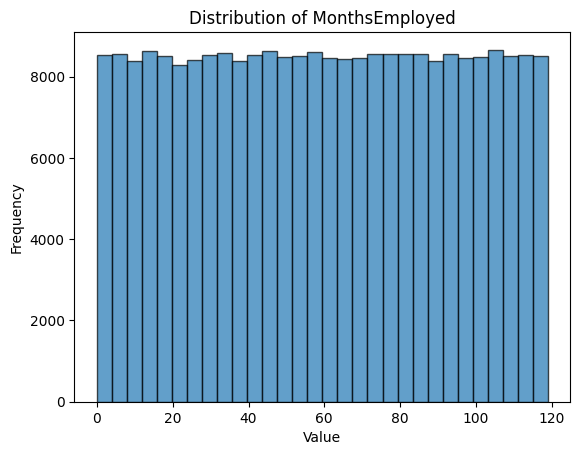

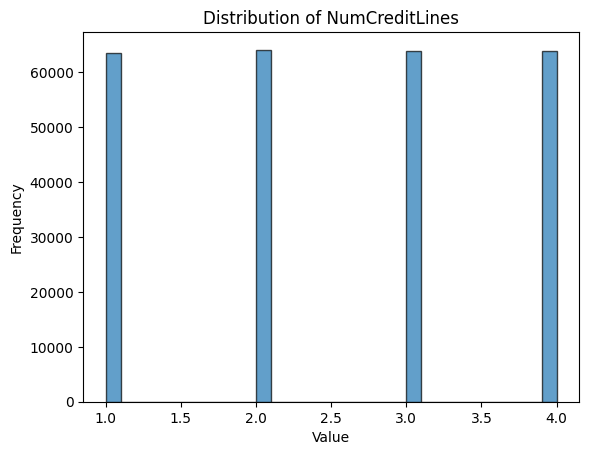

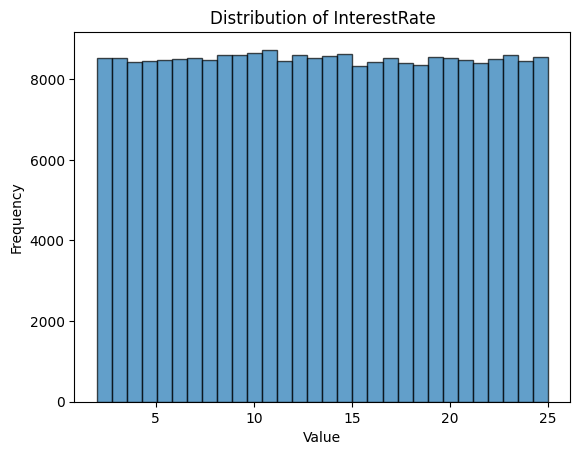

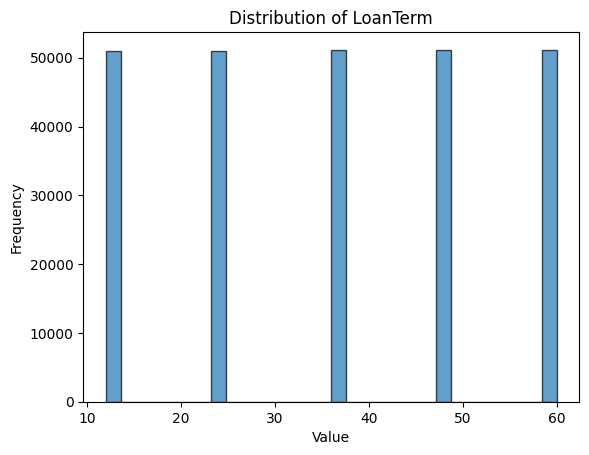

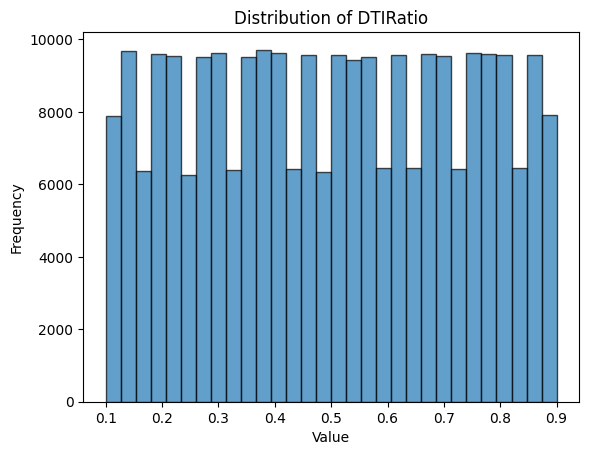

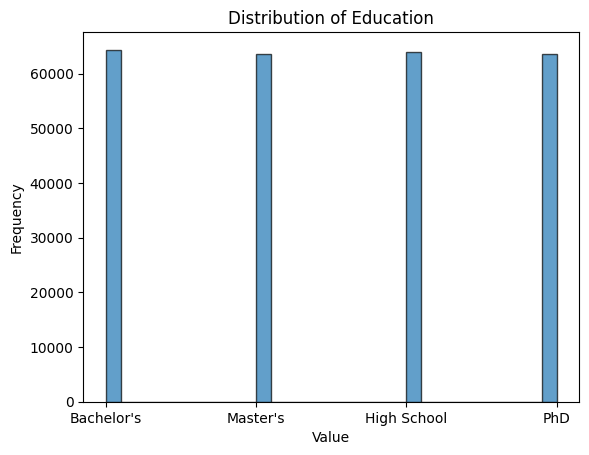

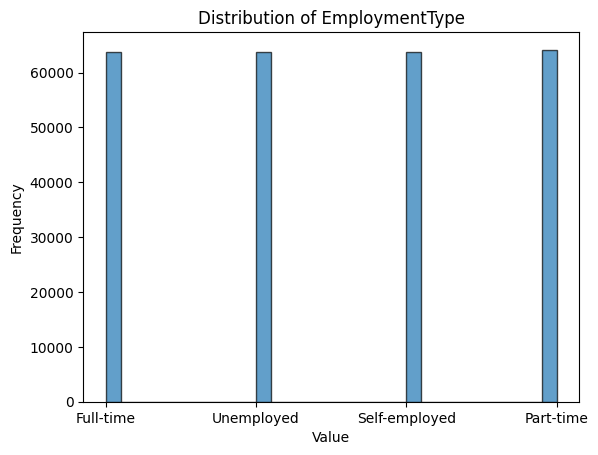

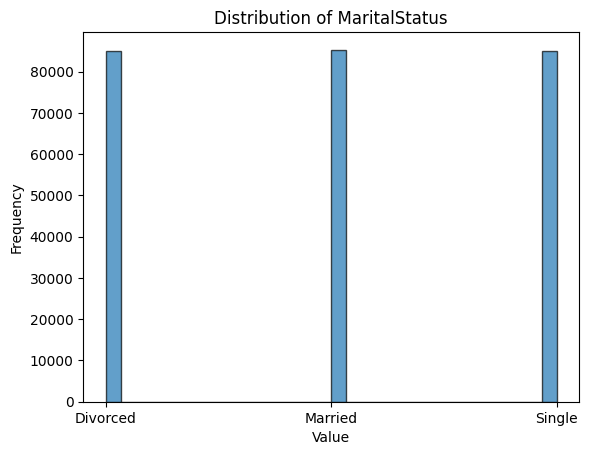

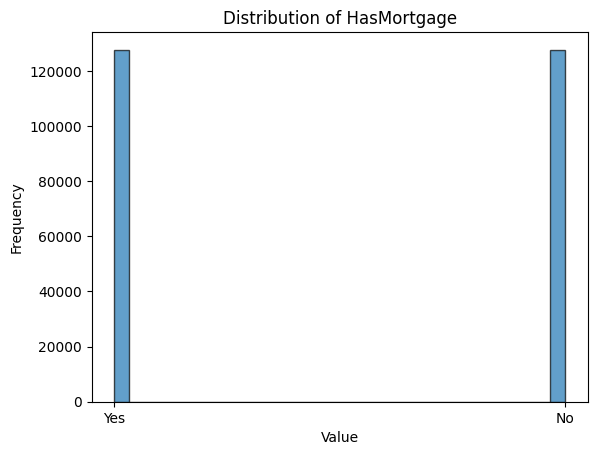

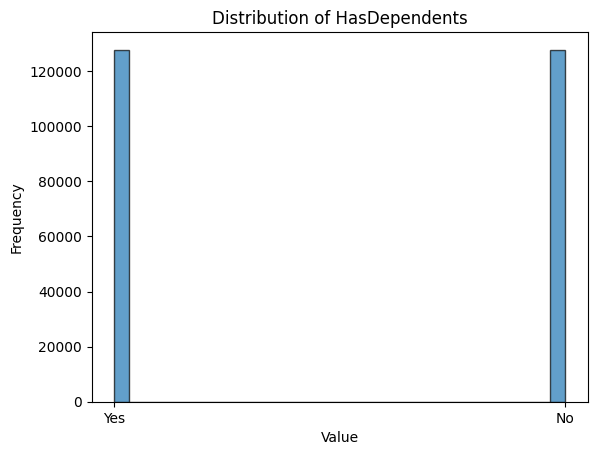

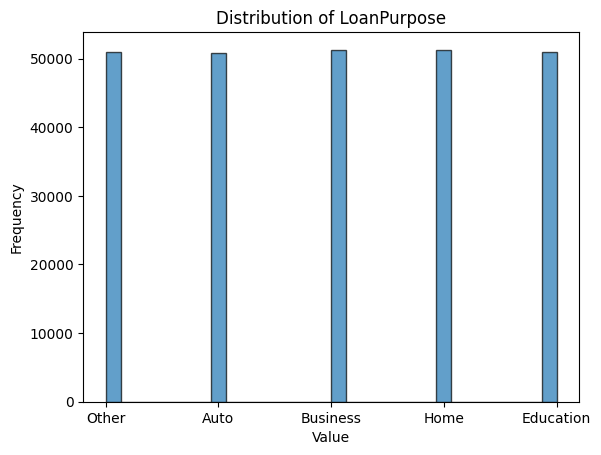

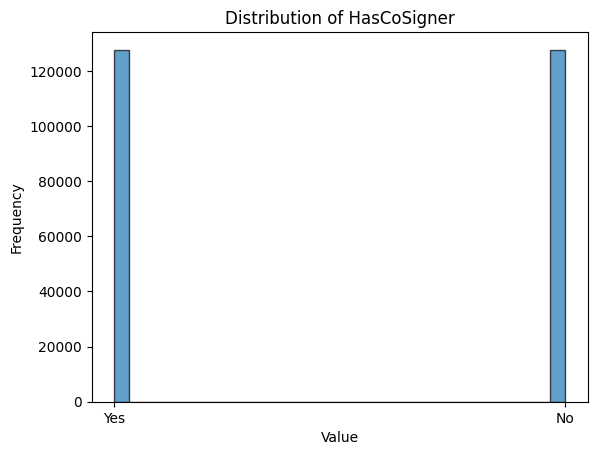

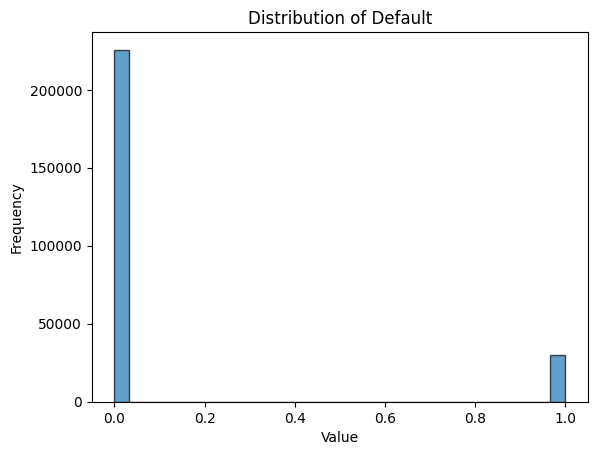

In [9]:
# Plot histograms for each variable
for column in df.columns:
    plt.hist(df[column], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

The distribution for each variable is uniform for the most part. The graphs with low points in them are also most likely a uniform distribution as well, but the appearance may have been influenced by how the values are binned. 

In [40]:
count = 0
for val in df['LoanID'].duplicated():
    if val == True:
        count+=1
print(count)        

0


No duplicate entries present

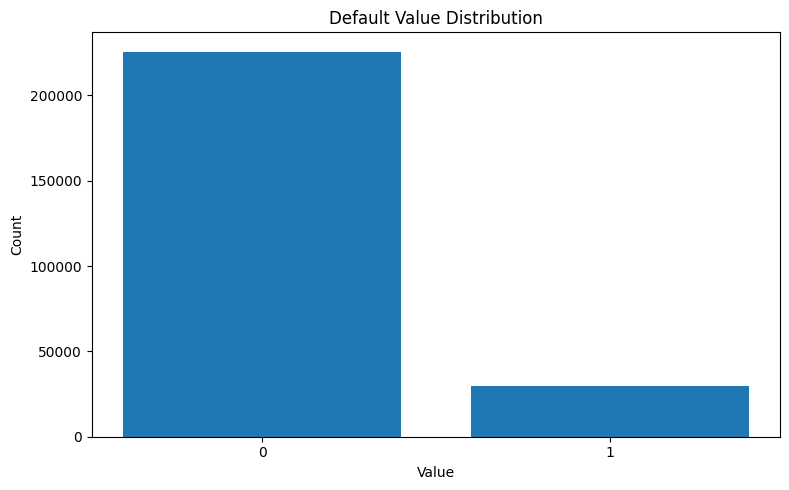

In [10]:
# Count the occurrences of each label value
counts = df['Default'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values)

# Adding title and labels
plt.title('Default Value Distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(ticks=[0,1])
plt.tight_layout()

Data is highly imbalanced, potentially biasing the models that will be trained on the data.

In [11]:
df.dtypes

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

# 2. Encoding Categorical Features and Standardizing Numerical Features

In [12]:
# use ordinal encoding for categorical features

# get the categorical and numerical features
categorical_features = df.select_dtypes(include='object').columns.drop('LoanID')
numerical_features = df.select_dtypes(include='number').columns.drop('Default')

# initialize OrdinalEncoder
ordinal = OrdinalEncoder()

# ordinal encode the data --> returns a numpy array
ordinal_encoded = ordinal.fit_transform(df[categorical_features])

# make a DataFrame with the ordinal encoded data
ordinal_encoded_df = pd.DataFrame(ordinal_encoded, columns=categorical_features)

# concatenate with the original DataFrame after dropping the original unencoded categorical features to grab the numerical features
df_ordinal = pd.concat([df.drop(columns=categorical_features).reset_index(drop=True), ordinal_encoded_df.reset_index(drop=True)], axis=1)
df_ordinal = df_ordinal.drop(columns=['LoanID'])

# Initialize StandardScaler
scaler = StandardScaler()

df_ordinal[numerical_features] = scaler.fit_transform(df[numerical_features])

df_ordinal

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,0.833990,0.089693,-1.086833,-0.341492,0.590533,1.341937,0.261771,-0.001526,-0.260753,0,0.0,0.0,0.0,1.0,1.0,4.0,1.0
1,1.701221,-0.823021,-0.044309,-0.731666,-1.285731,-1.343791,-1.308350,1.412793,0.778585,0,2.0,0.0,1.0,0.0,0.0,4.0,1.0
2,0.166888,0.043854,0.022715,-0.775718,-0.968209,0.446694,1.156831,-0.708685,-0.823728,1,2.0,3.0,0.0,1.0,1.0,0.0,0.0
3,-0.767053,-1.303452,-1.168538,1.061875,-1.718715,0.446694,-0.967805,-0.708685,-1.170174,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.100830,-1.592855,-1.671921,0.369631,-1.487790,1.341937,-1.052188,0.705634,0.995114,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,-1.634285,-1.142632,1.173101,-0.209337,1.427636,1.341937,0.093006,-1.415845,1.514783,0,0.0,0.0,1.0,0.0,0.0,4.0,0.0
255343,-0.767053,-0.783984,0.879724,-0.398130,-1.314597,-0.448549,-0.292744,-0.708685,-1.256785,1,1.0,1.0,0.0,0.0,0.0,3.0,0.0
255344,0.833990,0.059562,1.139391,0.143078,0.301877,0.446694,-1.236022,1.412793,-0.000918,0,1.0,2.0,1.0,1.0,1.0,0.0,1.0
255345,-0.099952,0.066979,-0.945840,1.477221,-0.564091,-1.343791,1.116146,0.705634,-0.260753,0,1.0,1.0,2.0,1.0,1.0,4.0,0.0


### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

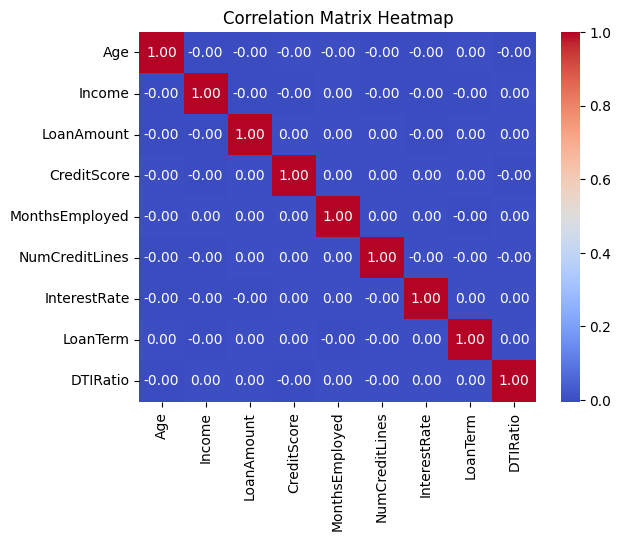

In [13]:
# Calculate and visualize the correlation matrix
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')

Unusually, none of the variables have any correlation with one another. This is another sign that the dataset was generated, rather than collected from the real-world.

### Save preprocessed dataset to use for models

In [14]:
df_ordinal.to_csv('./preprocessed_data.csv')

Ordinal encoding was used for its simplicity compared to one-hot encoding. Furthermore, the accuracies for the baseline model trained using ordinal encoded data vs one-hot encoded data were identical, with feature selection for ordinal encoded data being significantly faster due to lower dimensionality.

# 3. Train a baseline model to look at evaluation metrics

In [15]:
X = df_ordinal.drop(['Default'], axis=1)
y = df_ordinal['Default']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

# Train classifier using all features
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using accuracy and f1
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')

Accuracy: 0.8849030742118661
F1-score: 0.06291848230417685


In [16]:
y_pred.sum()

513

There are 513 positive predictions.

In [17]:
y_test.sum()

8896

There are 8896 actual positive class members.

Although the accuracy is high, a minority of the positive class, Default=1 (Default), is being classified correctly. This is because the dataset is imbalanced, so training is biased towards recognizing members of the majority class, which is Default=0 (Not Default).
Because the dataset is imbalanced and it's important to minimize false negatives as much as possible, f1 will be used as the scoring metric

# Feature selection methods

In [18]:
n_features = df_ordinal.shape[1] - 1 

## *k*-best features 

In [19]:
def k_best(metric):
    k_best_score_list = []

    # Iterate over a range of features to select
    for k in tqdm(range(1, n_features + 1), desc=f"K Best with {metric} Progress"):
        # Select K Best features
        k_best_selector = SelectKBest(mutual_info_classif, k=k)
        k_best_selector.fit(X_train, y_train)
        
        # Transform train and test datasets
        sel_X_train = k_best_selector.transform(X_train)
        sel_X_test = k_best_selector.transform(X_test)
        
        # Fit the model with selected features
        model.fit(sel_X_train, y_train)
        k_best_preds = model.predict(sel_X_test)
        
        if metric == 'accuracy':
            # Calculate accuracy score
            accuracy = accuracy_score(y_test, k_best_preds)
            k_best_score_list.append(accuracy)
        else:
            # Calculate F1-score
            f1 = f1_score(y_test, k_best_preds, average='binary')  # Use 'binary' for binary classification
            k_best_score_list.append(f1)
    
    return k_best_score_list # return list of scores

def run_model_and_report(model, selector):
    model.fit(sel_X_train, y_train)
    preds = model.predict(sel_X_test)

    # Report selected features
    selected_feature_mask = selector.get_support()
    selected_features = X_train.columns[selected_feature_mask]
    print(f"Chosen features: {list(selected_features)}")

    # Calculate accuracy
    acc = accuracy_score(y_test, preds)
    print(f"Accuracy = {acc}")
    
    # Calculate f1 
    f1 = f1_score(y_test, preds, average='binary')  # Use 'binary' for binary classification
    print(f"F1 = {f1}")

In [20]:
k_acc_list = k_best(metric='accuracy')
print(k_acc_list)

K Best with accuracy Progress: 100%|██████████| 16/16 [04:48<00:00, 18.02s/it]

[0.8838718099340774, 0.8838718099340774, 0.8838718099340774, 0.8838718099340774, 0.8838718099340774, 0.8838718099340774, 0.8838718099340774, 0.8838718099340774, 0.8839501338032766, 0.8838718099340774, 0.8839501338032766, 0.8839501338032766, 0.8839501338032766, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661]


In [21]:
k_f1_list = k_best('f1')
print(k_f1_list)

K Best with f1 Progress: 100%|██████████| 16/16 [04:43<00:00, 17.70s/it]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00022466861379465288, 0.02947598253275109, 0.02947598253275109, 0.02947598253275109, 0.02947598253275109, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685]


In [22]:
# Print rounded accuracy and f1 scores
print(f'Accuracies: {[round(score, 3) for score in k_acc_list]}')
print(f'F1-scores: {[round(score, 3) for score in k_f1_list]}')

Accuracies: [0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.885, 0.885, 0.885]
F1-scores: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029, 0.029, 0.029, 0.029, 0.063, 0.063, 0.063]


In [23]:
def plot_scores(scores_list, method_name, metric):
    x = np.arange(1, len(scores_list)+1)
    y = [round(score, 3) for score in scores_list]

    _, ax = plt.subplots(figsize=(8, 6))

    # Create the vertical bar plot
    bars = ax.bar(x, y, width=0.4, color='lightblue')

    # Set x and y labels
    ax.set_xlabel('Number of features selected')
    ax.set_ylabel(f'{metric}')
    ax.set_ylim(0, 1.0)

    # Set custom ticks for x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(1, len(scores_list)+1))

    # Add value labels above the bars
    for bar, value in zip(bars, y):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, f'{value:.3f}', ha='center')
        
    plt.title(f'{method_name} {metric} scores')
    plt.tight_layout()

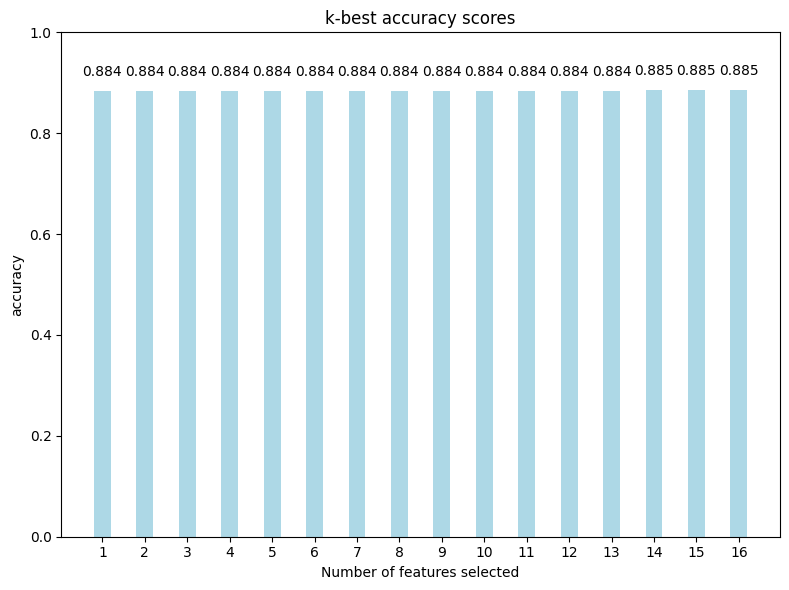

In [24]:
plot_scores(k_acc_list, 'k-best', 'accuracy')

Hardly any improvement accuracy-wise

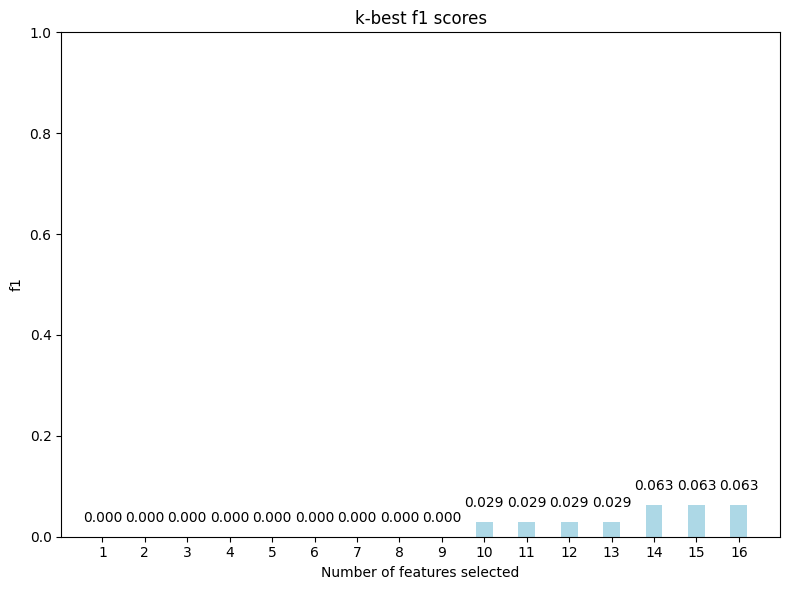

In [25]:
plot_scores(k_f1_list, 'k-best', 'f1')

Using f1-scores paints an entirely different picture. The increases in f1-scores with greater features are more noticeable.

In [26]:
# Model with the best number of features according to k_best_selector
k_best_selector = SelectKBest(mutual_info_classif, k=16)
k_best_selector.fit(X_train, y_train)
sel_X_train = k_best_selector.transform(X_train)
sel_X_test = k_best_selector.transform(X_test)

run_model_and_report(model=model,selector=k_best_selector)

Chosen features: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
Accuracy = 0.8849030742118661
F1 = 0.06291848230417685


As the performance was better with more features, we will be using all features, with the exception of 'LoanID', which is just for identification purposes and therefore yields no meaningful information on loan defaults.

## Recursive feature elimination (RFE) 

In [27]:
from sklearn.feature_selection import RFE

rfe_acc_list = []
rfe_f1_list = []

# Use tqdm to track the progress of the loop
for k in tqdm(range(1, n_features + 1), desc="RFE Progress"):
    RFE_selector = RFE(estimator=model, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train, y_train)
    
    sel_X_train = RFE_selector.transform(X_train)
    sel_X_test = RFE_selector.transform(X_test)
    
    model.fit(sel_X_train, y_train)
    RFE_preds = model.predict(sel_X_test)

    acc = accuracy_score(y_test, RFE_preds)
    rfe_acc_list.append(acc)
    
    f1 = f1_score(y_test, RFE_preds, average='binary')
    rfe_f1_list.append(f1)


RFE Progress: 100%|██████████| 16/16 [01:42<00:00,  6.41s/it]


In [28]:
print(rfe_acc_list)

[0.8838718099340774, 0.8838718099340774, 0.8839501338032766, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661, 0.8849030742118661]


In [29]:
print(rfe_f1_list)

[0.0, 0.0, 0.02947598253275109, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685, 0.06291848230417685]


In [30]:
# Print rounded accuracy and f1 scores
print(f'Accuracies: {[round(score, 3) for score in rfe_acc_list]}')
print(f'F1-scores: {[round(score, 3) for score in rfe_f1_list]}')

Accuracies: [0.884, 0.884, 0.884, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885, 0.885]
F1-scores: [0.0, 0.0, 0.029, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063, 0.063]


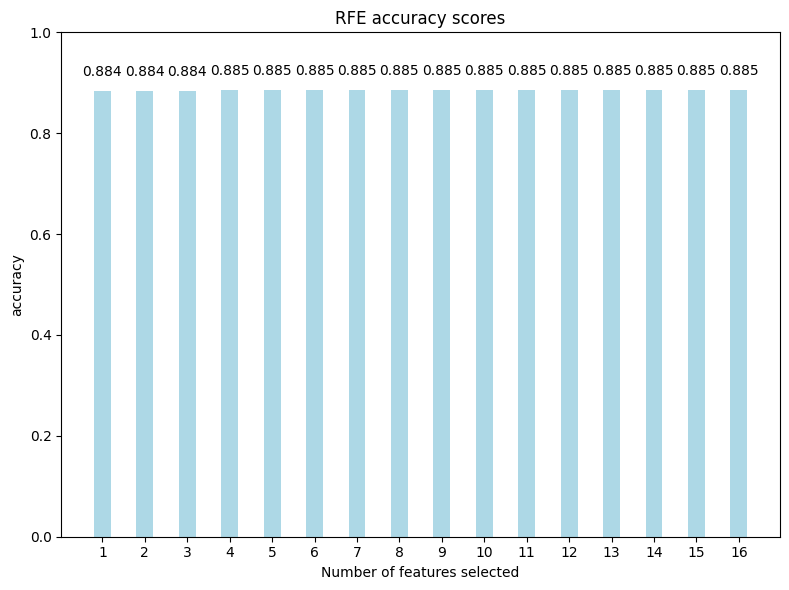

In [31]:
plot_scores(rfe_acc_list, 'RFE', 'accuracy')

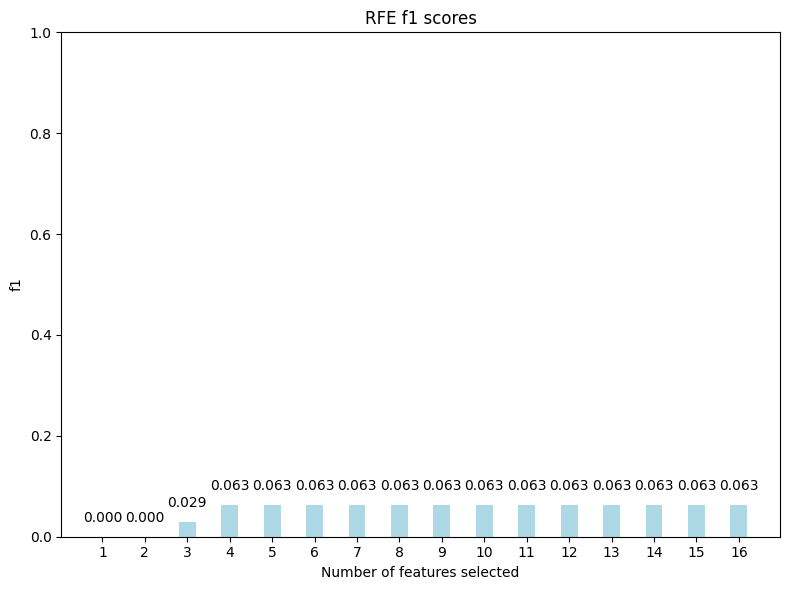

In [32]:
plot_scores(rfe_f1_list, 'RFE', 'f1')

In [33]:
# Model with the best number of features according to RFE_selector
RFE_selector = RFE(estimator=model, n_features_to_select=14, step=1)
RFE_selector.fit(X_train, y_train)
sel_X_train = RFE_selector.transform(X_train)
sel_X_test = RFE_selector.transform(X_test)

run_model_and_report(model=model,selector=RFE_selector)

Chosen features: ['Age', 'Income', 'LoanAmount', 'MonthsEmployed', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
Accuracy = 0.8849030742118661
F1 = 0.06291848230417685


Both k-best and RFE have comparable accuracies and f1-scores to the baseline model. Therefore, we will be using those feature selection techiniques.

## Variance threshold

In [34]:
# Calculate the variance of each feature
X_train.var(axis=0)

Age               1.000221
Income            1.000012
LoanAmount        1.000632
CreditScore       1.001295
MonthsEmployed    1.000910
NumCreditLines    0.999382
InterestRate      0.999982
LoanTerm          1.001278
DTIRatio          1.000164
Education         1.252505
EmploymentType    1.247421
MaritalStatus     0.666098
HasMortgage       0.250001
HasDependents     0.250001
LoanPurpose       1.995848
HasCoSigner       0.250001
dtype: float64

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)

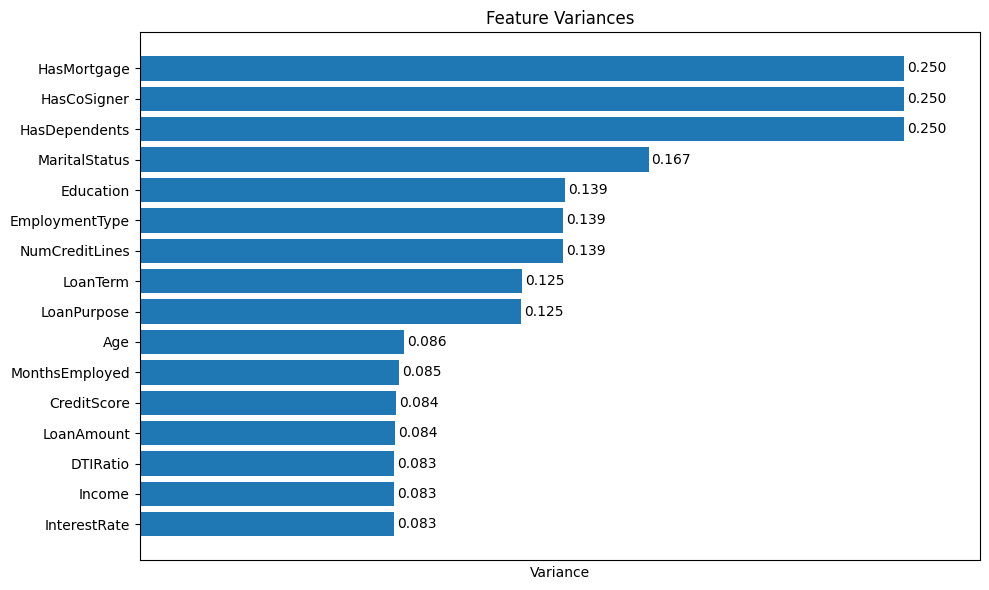

In [36]:
# Plot sorted variances
x = X.columns
y = scaled_X_train.var(axis=0)

# Sort the features and variance values
sorted_indices = np.argsort(y)[::-1]  # Sorting in descending order
sorted_x = x[sorted_indices]          # Sorted feature names
sorted_y = y[sorted_indices]          # Sorted variances

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_x, sorted_y)

# Add value labels next to the bars
for bar, value in zip(bars, sorted_y):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{value:.3f}', va='center')

# Adjust x-axis limit to prevent clipping
plt.xlim(0, max(sorted_y) * 1.1)

# Remove x-ticks
plt.xticks([])

# Set labels and title
plt.xlabel('Variance')
plt.title('Feature Variances')

# Invert y-axis to have the most variance at the top
plt.gca().invert_yaxis()

plt.tight_layout()


In [37]:
X_train_dropped = X_train.drop(['DTIRatio', 'Income', 'InterestRate'], axis=1)
X_test_dropped = X_test.drop(['DTIRatio', 'Income', 'InterestRate'], axis=1)

model.fit(X_train_dropped, y_train)

# Make predictions
preds = model.predict(X_test_dropped)

# Evaluate the model using accuracy
f1 = f1_score(y_test, preds, average='binary')
print(f1)

0.0


Variance threshold has the lowest f1-score. We're not going to use it. Sequential feature elimination and sequential feature selection had been explored in the early stages of this project, but were ultimately thrown out as they were not able to deliver timely results due to the dataset being large.